In [1]:
import tensorflow as tf
import datetime
from tensorflow.keras import datasets, layers, models
from keras.callbacks import TensorBoard
from tensorflow.keras.layers import *
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from skopt.utils import use_named_args
from tensorflow.python.keras.callbacks import EarlyStopping
from skopt import callbacks
from skopt.callbacks import CheckpointSaver
from tensorflow.keras.optimizers import *
import gc
from tensorflow_addons.optimizers import CyclicalLearningRate

C:\Users\Weronika Gramacka\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Weronika Gramacka\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Weronika Gramacka\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)

In [3]:
x_train = train_images.astype('float32') / 255.
x_test = test_images.astype('float32') / 255.
y_train = keras.utils.to_categorical(train_labels, 10)
y_test = keras.utils.to_categorical(test_labels, 10)

In [4]:
datagen = ImageDataGenerator()
datagen.fit(x_train)

In [30]:
x_test.shape

(10000, 32, 32, 3)

In [31]:
train_images.shape

(50000, 32, 32, 3)

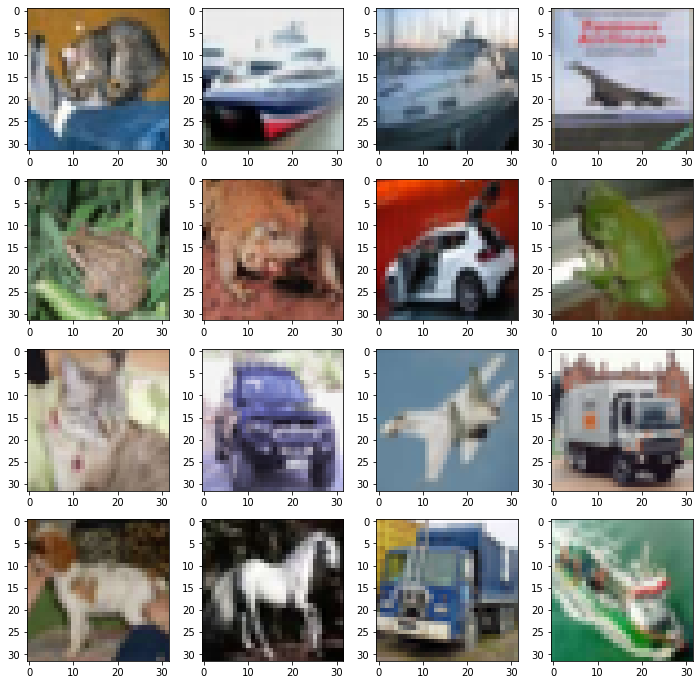

In [32]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(test_images[0:16], axs):
    ax.imshow(img)

# Autoencoder

In [33]:
def autoencoder(optimizer):
    model = models.Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2048,activation='relu'))
    model.add(Dense(3072, activation='sigmoid'))
    model.add(Reshape((32,32,3)))
    model.compile(loss = 'mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

In [38]:
keras.backend.clear_session()
model = autoencoder('SGD')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              6

In [39]:
log_dir = "Tensor_board/04_ev/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir='log_dir',
    histogram_freq=1,
    write_graph=True,
    write_grads=False,
    write_images=False)

history = model.fit_generator(datagen.flow(x_train, x_train, batch_size=1024),
                    epochs=100,
                    validation_data = (x_test, x_test),
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/100
49/49 [==============================] - 5s 84ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 2/100
49/49 [==============================] - 4s 78ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 3/100
49/49 [==============================] - 4s 74ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 4/100
49/49 [==============================] - 4s 78ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 5/100
49/49 [==============================] - 4s 74ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 6/100
49/49 [==============================] - 4s 77ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 7/100
49/49 [=========

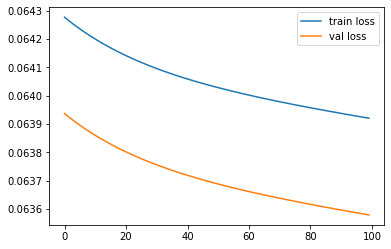

In [40]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

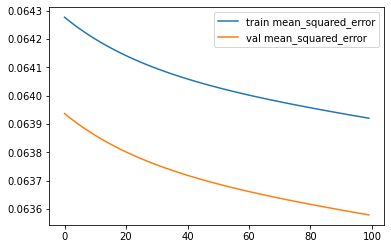

In [41]:
plt.plot(history.history['mean_squared_error'], label='train mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val mean_squared_error')
plt.legend()
plt.show()

In [42]:
decoded_imgs = model.predict(x_test)

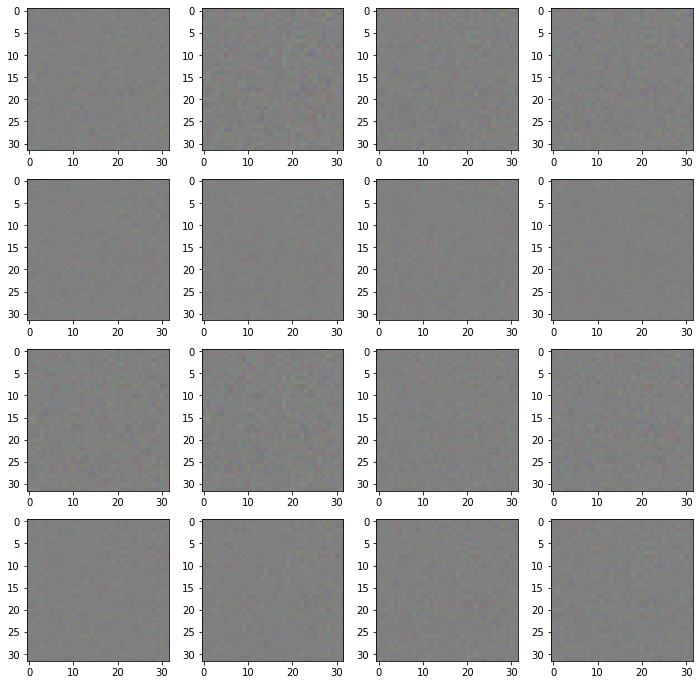

In [43]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(decoded_imgs[0:16], axs):
    ax.imshow(img)

## Comment

### Zadany w zadaniu opimalizer nie pozwolił uzykać oczykiwanego efektu działania autoencodera. Poniżej działanie encodera przy wykorzystaniu optimizera "Adam"

In [45]:
keras.backend.clear_session()
model = autoencoder('Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              6

In [46]:
log_dir = "Tensor_board/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir='log_dir',
    histogram_freq=1,
    write_graph=True,
    write_grads=False,
    write_images=False)

history = model.fit_generator(datagen.flow(x_train, x_train, batch_size=1024),
                    epochs=100,
                    validation_data = (x_test, x_test),
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/100
49/49 [==============================] - 6s 103ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 2/100
49/49 [==============================] - 4s 79ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 3/100
49/49 [==============================] - 4s 79ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 4/100
49/49 [==============================] - 4s 81ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 5/100
49/49 [==============================] - 4s 78ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 6/100
49/49 [==============================] - 4s 79ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 7/100
49/49 [========

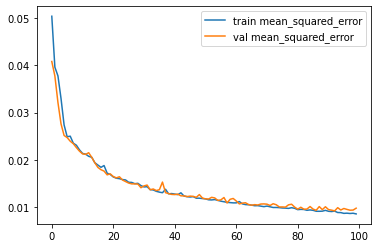

In [48]:
plt.plot(history.history['mean_squared_error'], label='train mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val mean_squared_error')
plt.legend()
plt.show()

In [49]:
decoded_imgs = model.predict(x_test)

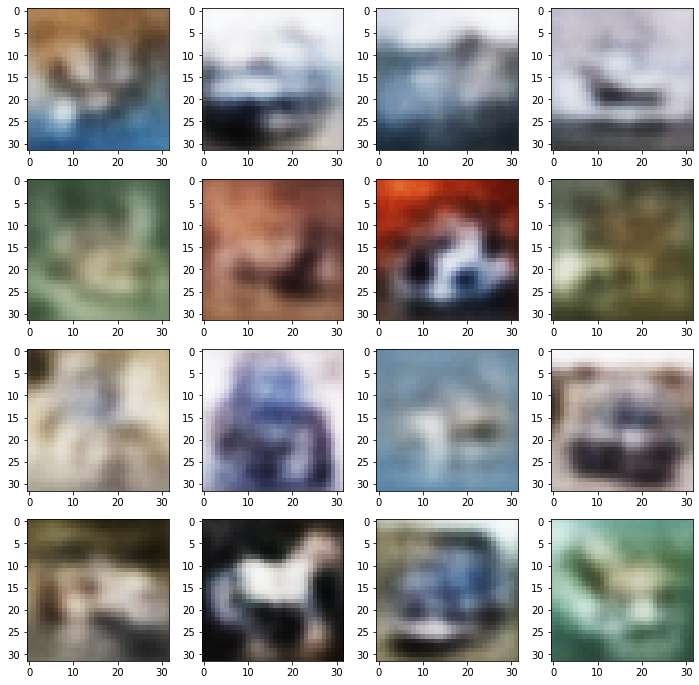

In [50]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(decoded_imgs[0:16], axs):
    ax.imshow(img)

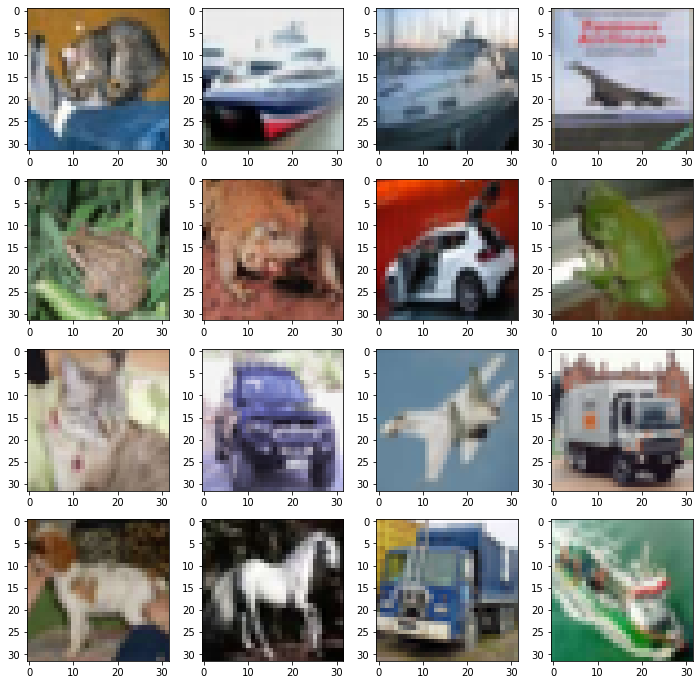

In [51]:
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(x_test[0:16], axs):
    ax.imshow(img)

 ## Comment
 ### Przez wszystkie epoki odbywał się proces uczenia, zajwisko overffitingu zaczęło pojawiać się w procesie uczenia około 90 epoki, błąd średniokwadratowy dla zbioru uczącego cały czas obniżał się, a dla zbioru walidacyjnego zaczął się w niewielkim stopniu zwiększać. Udało się uzyskać oczekiwany wynik, zrekonstruowane obrazy są "zamglonymi" odpowiednikami obrazów orginalnych.

# Klasyfikator

In [52]:
autoencoder = model


In [53]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              6

(50000, 1)

In [109]:
def classificator():
    model = models.Sequential()
    for layer in autoencoder.layers[0:4]:
        layer.trainable=False
        model.add(layer)
    model.add(Dense(128, activation='relu', name = 'dense1'))
    model.add(Dense(10, activation='softmax', name = 'dense2'))
    model.compile(loss = 'categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [110]:
keras.backend.clear_session()
model = classificator()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense1 (Dense)               (None, 128)               65664     
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 8,983,434
Trainable params: 66,954
Non-trainable params: 8,916,480
_________________________________________

In [112]:
log_dir = "Tensor_board/classificator/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir='log_dir',
    histogram_freq=1,
    write_graph=True,
    write_grads=False,
    write_images=False)

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=100,
                    validation_data = (x_test, y_test),
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/100
391/391 [==============================] - 3s 7ms/step - loss: 1.9496 - accuracy: 0.3277 - val_loss: 1.9049 - val_accuracy: 0.3427
Epoch 2/100
391/391 [==============================] - 2s 6ms/step - loss: 1.8834 - accuracy: 0.3488 - val_loss: 1.8541 - val_accuracy: 0.3608
Epoch 3/100
391/391 [==============================] - 2s 6ms/step - loss: 1.8424 - accuracy: 0.3620 - val_loss: 1.8228 - val_accuracy: 0.3744
Epoch 4/100
391/391 [==============================] - 2s 6ms/step - loss: 1.8133 - accuracy: 0.3716 - val_loss: 1.7964 - val_accuracy: 0.3824
Epoch 5/100
391/391 [==============================] - 2s 6ms/step - loss: 1.7900 - accuracy: 0.3800 - val_loss: 1.7771 - val_accuracy: 0.3832
Epoch 6/100
391/391 [==============================] - 2s 6ms/step - loss: 1.7718 - accuracy: 0.3865 - val_loss: 1.7588 - val_accuracy: 0.3918
Epoch 7/100
391/391 [==============================] - 2s 6ms/step - loss: 1.7561 - accuracy: 0.3917 - val_loss: 1.7451 - val_accuracy: 0.3951

Epoch 58/100
391/391 [==============================] - 2s 6ms/step - loss: 1.5037 - accuracy: 0.4706 - val_loss: 1.5141 - val_accuracy: 0.4630
Epoch 59/100
391/391 [==============================] - 2s 6ms/step - loss: 1.5007 - accuracy: 0.4711 - val_loss: 1.5100 - val_accuracy: 0.4672
Epoch 60/100
391/391 [==============================] - 2s 6ms/step - loss: 1.4980 - accuracy: 0.4727 - val_loss: 1.5076 - val_accuracy: 0.4702
Epoch 61/100
391/391 [==============================] - 2s 6ms/step - loss: 1.4951 - accuracy: 0.4719 - val_loss: 1.5049 - val_accuracy: 0.4725
Epoch 62/100
391/391 [==============================] - 2s 6ms/step - loss: 1.4923 - accuracy: 0.4750 - val_loss: 1.5047 - val_accuracy: 0.4704
Epoch 63/100
391/391 [==============================] - 2s 6ms/step - loss: 1.4893 - accuracy: 0.4753 - val_loss: 1.5004 - val_accuracy: 0.4744
Epoch 64/100
391/391 [==============================] - 2s 6ms/step - loss: 1.4867 - accuracy: 0.4764 - val_loss: 1.4979 - val_accuracy:

In [61]:
history.history

{'loss': [0.10053370147943497,
  0.08077505230903625,
  0.07835646718740463,
  0.07661835104227066,
  0.075298011302948,
  0.07364050298929214,
  0.07282854616641998,
  0.07148098200559616,
  0.07048668712377548,
  0.06964243948459625,
  0.06859491765499115,
  0.06785017251968384,
  0.0669071227312088,
  0.06616199016571045,
  0.06569109857082367,
  0.06501143425703049,
  0.0639740377664566,
  0.06375410407781601,
  0.06291261315345764,
  0.062413979321718216,
  0.06198059022426605,
  0.06121431291103363,
  0.06084546446800232,
  0.060739610344171524,
  0.06012698635458946,
  0.05954139679670334,
  0.05900018662214279,
  0.05861029401421547,
  0.05841643735766411,
  0.05786281079053879,
  0.05726434662938118,
  0.05717020854353905,
  0.05694279819726944,
  0.05637082830071449,
  0.0558343343436718,
  0.0556541346013546,
  0.055057451128959656,
  0.05474907532334328,
  0.05427178367972374,
  0.05397379398345947,
  0.05345785245299339,
  0.05341511592268944,
  0.05302131921052933,
  0.05

In [125]:
import numpy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
predictions = model.predict(x_test)
predicted_classes = numpy.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.52      0.56      1000
           1       0.61      0.61      0.61      1000
           2       0.38      0.30      0.34      1000
           3       0.36      0.35      0.35      1000
           4       0.40      0.42      0.41      1000
           5       0.43      0.35      0.39      1000
           6       0.46      0.62      0.53      1000
           7       0.56      0.52      0.54      1000
           8       0.56      0.66      0.61      1000
           9       0.53      0.57      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



<AxesSubplot:>

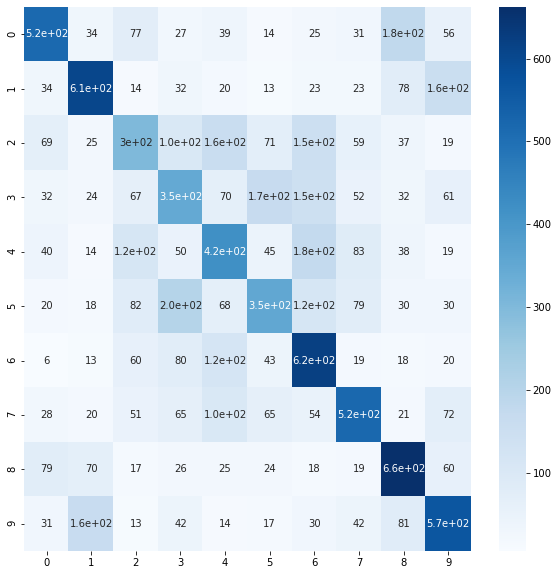

In [126]:
cf= confusion_matrix(test_labels, predicted_classes)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cf, annot=True, cmap='Blues', ax=ax)

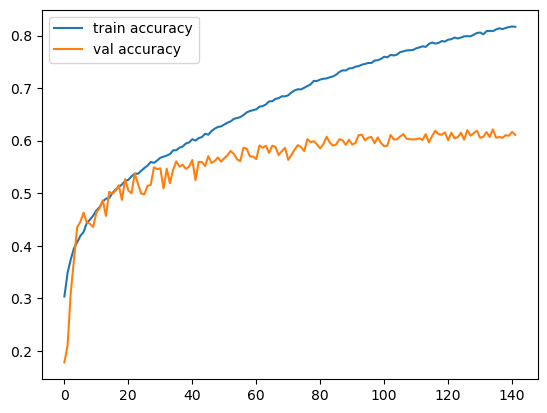

In [62]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

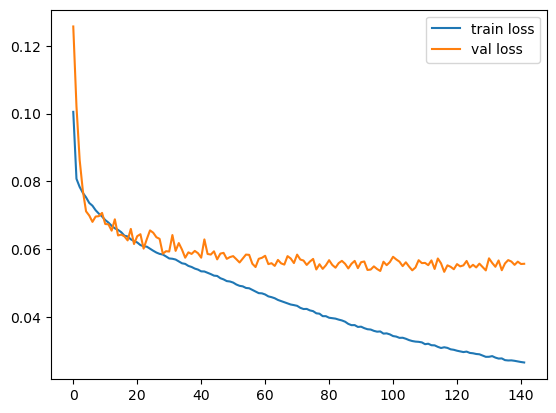

In [63]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Comment
### Model uzyskał niską dokładność na poziome  49%. Metryka accuracy wskazuje na to, że model często popełnia błędy w klasyfikacji zwłaszcza dla klas 2,3 i 5. Możliwe że przyuczenie modelu dla większej liczby epok pozwoliłoby na uzyskanie lepszego wyniku. We procesie uczenia nastąpiło zjawisko overfittingu, utrata dla zbioru uczącego jest dużo niższa niż dla zbioru walidacyjnego

# Classification corrected -> finding best model

In [27]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)

In [28]:
x_train = train_images.astype('float32') / 255.
x_test = test_images.astype('float32') / 255.
y_train = keras.utils.to_categorical(train_labels, 10)
y_test = keras.utils.to_categorical(test_labels, 10)

In [29]:
datagen = ImageDataGenerator(
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, )
datagen.fit(x_train)

In [30]:
dim_num_dense_nodes = Integer(low=256, high=3000, name='num_dense_nodes')
dim_num_dense_layers  =  Integer(low=1, high=5, name='num_dense_layers')
dim_activation = Categorical(categories=['sigmoid', 'tanh', 'softplus', 'softmax', 'relu'],
                             name='activation')
dim_dropout = Real(low=0.01, high=0.4, name='dropout')
dim_init = Categorical(
    categories=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal',
                'he_uniform'], name='kernel_initializer')
dim_optimizer = Categorical(categories=['RMSprop', 'Adam',  'Nadam', 'Adamax', 'SGD'], name='optimizer')
dim_loss = Categorical(categories=['categorical_crossentropy', 'categorical_hinge', 'mean_squared_error', 'huber_loss'],
                       name='loss')

In [31]:
dimensions = [dim_num_dense_nodes,
              dim_num_dense_layers,
              dim_activation,
              dim_dropout,
              dim_init,
              dim_optimizer,
              dim_loss]

In [32]:
default_parameters = [
 2048,
 2, 
 'relu',
 0.05,
 'he_normal',
 'Adam',
 'categorical_crossentropy']

In [33]:
def create_model( num_dense_nodes, num_dense_layers, activation, dropout, kernel_initializer, optimizer, loss):
    model = models.Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i + 1)
        model.add(Dense(num_dense_nodes,
                        kernel_initializer=kernel_initializer,
                        activation=activation,
                        name=name))
        num_dense_nodes = num_dense_nodes // 2
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss=loss, optimizer=get_optimizer(optimizer), metrics=['accuracy'])
    return model

In [34]:
def get_optimizer(opt):
    if opt == 'RMSprop':
        optimizer = RMSprop(learning_rate=0.001)
    if opt == 'Adam':
        optimizer = Adam(learning_rate=0.001)
    if opt == 'SGD':
        optimizer = SGD(learning_rate=0.001)
    if opt == 'Nadam':
        optimizer = Nadam()
    if opt == 'Adamax':
        optimizer = Adamax(learning_rate=0.001)
    return optimizer

In [35]:
best_accuracy = 0.0
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes, num_dense_layers, activation, dropout, kernel_initializer, optimizer, loss):
    # Print the hyper-parameters.
    print('num_dense_nodes:', num_dense_nodes)
    print('num_dense_layers', num_dense_layers)
    print('activation:', activation)
    print('dropout:', dropout)
    print('kernel_initializer', kernel_initializer)
    print('optimizer:', optimizer)
    print('loss:', loss)
    print()
    tf.random.set_seed(3)
    model = create_model(num_dense_nodes=num_dense_nodes,
                         num_dense_layers=num_dense_layers,
                         activation=activation,
                         dropout=dropout,
                         kernel_initializer=kernel_initializer,
                         optimizer=optimizer,
                         loss=loss)


    es = EarlyStopping(monitor='val_loss', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=True)
    es_acc = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, min_delta=0.00001, verbose=1, restore_best_weights=True)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1024),
                                  epochs=100,
                                  shuffle=True,
                                  validation_data = (x_test, y_test),
                                  callbacks=[es, es_acc])

    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy

    del model
    gc.collect()
    keras.backend.clear_session()
    return -accuracy

In [36]:
checkpoint_saver = CheckpointSaver("./checkpoint.pkl", compress=9)

In [37]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=40,
                            x0=default_parameters, verbose=True, callback=[checkpoint_saver])

Iteration No: 1 started. Evaluating function at provided point.
num_dense_nodes: 2048
num_dense_layers 2
activation: relu
dropout: 0.05
kernel_initializer he_normal
optimizer: Adam
loss: categorical_crossentropy

Epoch 1/100
49/49 [==============================] - 14s 279ms/step - loss: 2.0010 - accuracy: 0.3426 - val_loss: 3.0325 - val_accuracy: 0.2506
Epoch 2/100
49/49 [==============================] - 14s 275ms/step - loss: 1.6799 - accuracy: 0.4089 - val_loss: 2.3230 - val_accuracy: 0.2910
Epoch 3/100
49/49 [==============================] - 13s 273ms/step - loss: 1.6203 - accuracy: 0.4254 - val_loss: 2.1436 - val_accuracy: 0.3185
Epoch 4/100
49/49 [==============================] - 13s 274ms/step - loss: 1.5821 - accuracy: 0.4407 - val_loss: 1.7896 - val_accuracy: 0.3970
Epoch 5/100
49/49 [==============================] - 13s 273ms/step - loss: 1.5386 - accuracy: 0.4545 - val_loss: 1.7588 - val_accuracy: 0.3835
Epoch 6/100
49/49 [==============================] - 13s 273ms/step

Epoch 10/100
49/49 [==============================] - 14s 277ms/step - loss: 0.0450 - accuracy: 0.0989 - val_loss: 0.0450 - val_accuracy: 0.1000
Epoch 11/100
49/49 [==============================] - 14s 277ms/step - loss: 0.0450 - accuracy: 0.0984 - val_loss: 0.0450 - val_accuracy: 0.1000
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

Accuracy: 10.00%

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 151.6066
Function value obtained: -0.1000
Current minimum: -0.4033
Iteration No: 4 started. Evaluating function at random point.
num_dense_nodes: 2617
num_dense_layers 4
activation: softmax
dropout: 0.3064390216720388
kernel_initializer glorot_uniform
optimizer: Adamax
loss: categorical_hinge

Epoch 1/100
49/49 [==============================] - 14s 280ms/step - loss: 1.0003 - accuracy: 0.1014 - val_loss: 1.0003 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 14s 276ms/step - loss: 1.0001 - accuracy: 0.119

Epoch 1/100
49/49 [==============================] - 14s 277ms/step - loss: 0.0496 - accuracy: 0.2708 - val_loss: 0.0692 - val_accuracy: 0.1892
Epoch 2/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0434 - accuracy: 0.3116 - val_loss: 0.0615 - val_accuracy: 0.2189
Epoch 3/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0427 - accuracy: 0.3231 - val_loss: 0.0447 - val_accuracy: 0.3315
Epoch 4/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0421 - accuracy: 0.3316 - val_loss: 0.0584 - val_accuracy: 0.2235
Epoch 5/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0415 - accuracy: 0.3373 - val_loss: 0.0466 - val_accuracy: 0.3133
Epoch 6/100
49/49 [==============================] - 14s 278ms/step - loss: 0.0411 - accuracy: 0.3489 - val_loss: 0.0405 - val_accuracy: 0.3754
Epoch 7/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0409 - accuracy: 0.3499 - val_loss: 0.0440 - val_accuracy:

49/49 [==============================] - 14s 281ms/step - loss: 0.0286 - accuracy: 0.5615 - val_loss: 0.0331 - val_accuracy: 0.4800
Epoch 26/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0284 - accuracy: 0.5694 - val_loss: 0.0333 - val_accuracy: 0.4763
Restoring model weights from the end of the best epoch.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Epoch 00026: early stopping

Accuracy: 47.63%

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 345.3431
Function value obtained: -0.4763
Current minimum: -0.5024
Iteration No: 9 started. Evaluating function at random point.
num_dense_nodes: 1585
num_dense_layers 3
activation: relu
dropout: 0.17233597310434814
kernel_initializer uniform
optimizer: Adam
loss: mean_squared_error

Epoch 1/100
49/49 [==============================] - 14s 273ms/step - loss: 0.0840 - accuracy: 0.3182 - val_loss: 0.1447 - val_accuracy: 0.1345
Epoch 2/100
49/49 [====================

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 274ms/step - loss: 0.0916 - accuracy: 0.2908 - val_loss: 0.0919 - val_accuracy: 0.1921
Epoch 2/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0832 - accuracy: 0.3437 - val_loss: 0.0824 - val_accuracy: 0.3057
Epoch 3/100
49/49 [==============================] - 13s 268ms/step - loss: 0.0798 - accuracy: 0.3671 - val_loss: 0.0800 - val_accuracy: 0.3233
Epoch 4/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0773 - accuracy: 0.3833 - val_loss: 0.0789 - val_accuracy: 0.3452
Epoch 5/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0749 - accuracy: 0.4012 - val_loss: 0.0839 - val_accuracy: 0.2862
Epoch 6/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0731 - accuracy: 0.4170 - val_loss: 0.0853 - val_accuracy: 0.2455
Epoch 7/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0713 - accuracy: 0.4329 - val_loss: 0.0824 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 15s 279ms/step - loss: 0.0900 - accuracy: 0.0986 - val_loss: 0.0900 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 14s 282ms/step - loss: 0.0900 - accuracy: 0.0989 - val_loss: 0.0900 - val_accuracy: 0.1000
Epoch 3/100
49/49 [==============================] - 14s 280ms/step - loss: 0.0900 - accuracy: 0.0988 - val_loss: 0.0900 - val_accuracy: 0.1000
Epoch 4/100
49/49 [==============================] - 14s 280ms/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0900 - val_accuracy: 0.1000
Epoch 5/100
49/49 [==============================] - 14s 281ms/step - loss: 0.0900 - accuracy: 0.0972 - val_loss: 0.0900 - val_accuracy: 0.1000
Epoch 6/100
49/49 [==============================] - 14s 281ms/step - loss: 0.0900 - accuracy: 0.1074 - val_loss: 0.0900 - val_accuracy: 0.1000
Epoch 7/100
49/49 [==============================] - 14s 278ms/step - loss: 0.0881 - accuracy: 0.1522 - val_loss: 0.0908 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 273ms/step - loss: 0.0980 - accuracy: 0.2997 - val_loss: 0.1343 - val_accuracy: 0.1751
Epoch 2/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0802 - accuracy: 0.3647 - val_loss: 0.0893 - val_accuracy: 0.3055
Epoch 3/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0769 - accuracy: 0.3954 - val_loss: 0.0768 - val_accuracy: 0.3780
Epoch 4/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0743 - accuracy: 0.4162 - val_loss: 0.0760 - val_accuracy: 0.3987
Epoch 5/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0720 - accuracy: 0.4399 - val_loss: 0.0692 - val_accuracy: 0.4471
Epoch 6/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0699 - accuracy: 0.4569 - val_loss: 0.0762 - val_accuracy: 0.3896
Epoch 7/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0684 - accuracy: 0.4717 - val_loss: 0.0684 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 276ms/step - loss: 0.0618 - accuracy: 0.2702 - val_loss: 0.0555 - val_accuracy: 0.1083
Epoch 2/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0413 - accuracy: 0.3476 - val_loss: 0.0478 - val_accuracy: 0.1781
Epoch 3/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0374 - accuracy: 0.4018 - val_loss: 0.0442 - val_accuracy: 0.2287
Epoch 4/100
49/49 [==============================] - 14s 275ms/step - loss: 0.0362 - accuracy: 0.4241 - val_loss: 0.0421 - val_accuracy: 0.2662
Epoch 5/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0354 - accuracy: 0.4410 - val_loss: 0.0404 - val_accuracy: 0.2981
Epoch 6/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0347 - accuracy: 0.4525 - val_loss: 0.0362 - val_accuracy: 0.4158
Epoch 7/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0342 - accuracy: 0.4623 - val_loss: 0.0370 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 284ms/step - loss: 0.0632 - accuracy: 0.2793 - val_loss: 0.0620 - val_accuracy: 0.2629
Epoch 2/100
49/49 [==============================] - 14s 278ms/step - loss: 0.0478 - accuracy: 0.3389 - val_loss: 0.0515 - val_accuracy: 0.2399
Epoch 3/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0403 - accuracy: 0.3672 - val_loss: 0.0440 - val_accuracy: 0.3017
Epoch 4/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0388 - accuracy: 0.3854 - val_loss: 0.0409 - val_accuracy: 0.3435
Epoch 5/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0381 - accuracy: 0.3952 - val_loss: 0.0375 - val_accuracy: 0.3954
Epoch 6/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0375 - accuracy: 0.4065 - val_loss: 0.0362 - val_accuracy: 0.4255
Epoch 7/100
49/49 [==============================] - 14s 275ms/step - loss: 0.0372 - accuracy: 0.4113 - val_loss: 0.0352 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 278ms/step - loss: 0.1038 - accuracy: 0.2651 - val_loss: 0.1771 - val_accuracy: 0.1004
Epoch 2/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0804 - accuracy: 0.3450 - val_loss: 0.1300 - val_accuracy: 0.1183
Epoch 3/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0768 - accuracy: 0.3798 - val_loss: 0.1104 - val_accuracy: 0.2061
Epoch 4/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0752 - accuracy: 0.3930 - val_loss: 0.0955 - val_accuracy: 0.2416
Epoch 5/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0741 - accuracy: 0.4045 - val_loss: 0.1069 - val_accuracy: 0.1967
Epoch 6/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0734 - accuracy: 0.4127 - val_loss: 0.0822 - val_accuracy: 0.3192
Epoch 7/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0729 - accuracy: 0.4139 - val_loss: 0.0781 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 15s 282ms/step - loss: 0.0875 - accuracy: 0.2894 - val_loss: 0.0904 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 14s 278ms/step - loss: 0.0799 - accuracy: 0.3531 - val_loss: 0.0893 - val_accuracy: 0.1564
Epoch 3/100
49/49 [==============================] - 14s 275ms/step - loss: 0.0763 - accuracy: 0.3873 - val_loss: 0.0872 - val_accuracy: 0.1691
Epoch 4/100
49/49 [==============================] - 14s 279ms/step - loss: 0.0735 - accuracy: 0.4111 - val_loss: 0.0850 - val_accuracy: 0.2242
Epoch 5/100
49/49 [==============================] - 14s 279ms/step - loss: 0.0712 - accuracy: 0.4322 - val_loss: 0.0798 - val_accuracy: 0.3409
Epoch 6/100
49/49 [==============================] - 14s 280ms/step - loss: 0.0692 - accuracy: 0.4494 - val_loss: 0.0740 - val_accuracy: 0.4106
Epoch 7/100
49/49 [==============================] - 14s 278ms/step - loss: 0.0674 - accuracy: 0.4674 - val_loss: 0.0747 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 274ms/step - loss: 0.0450 - accuracy: 0.0986 - val_loss: 0.0450 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0450 - accuracy: 0.0980 - val_loss: 0.0450 - val_accuracy: 0.1000
Epoch 3/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0450 - accuracy: 0.0998 - val_loss: 0.0450 - val_accuracy: 0.1000
Epoch 4/100
49/49 [==============================] - 14s 275ms/step - loss: 0.0450 - accuracy: 0.1001 - val_loss: 0.0450 - val_accuracy: 0.1000
Epoch 5/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0450 - accuracy: 0.0983 - val_loss: 0.0450 - val_accuracy: 0.1000
Epoch 6/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0450 - accuracy: 0.1001 - val_loss: 0.0450 - val_accuracy: 0.1000
Epoch 7/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0450 - accuracy: 0.0976 - val_loss: 0.0450 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 271ms/step - loss: 0.0874 - accuracy: 0.3047 - val_loss: 0.0893 - val_accuracy: 0.2394
Epoch 2/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0783 - accuracy: 0.3650 - val_loss: 0.0805 - val_accuracy: 0.3179
Epoch 3/100
49/49 [==============================] - 13s 268ms/step - loss: 0.0763 - accuracy: 0.3850 - val_loss: 0.0778 - val_accuracy: 0.3562
Epoch 4/100
49/49 [==============================] - 13s 268ms/step - loss: 0.0746 - accuracy: 0.4011 - val_loss: 0.0743 - val_accuracy: 0.3942
Epoch 5/100
49/49 [==============================] - 13s 268ms/step - loss: 0.0736 - accuracy: 0.4113 - val_loss: 0.0754 - val_accuracy: 0.3814
Epoch 6/100
49/49 [==============================] - 13s 267ms/step - loss: 0.0725 - accuracy: 0.4251 - val_loss: 0.0747 - val_accuracy: 0.3868
Epoch 7/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0716 - accuracy: 0.4323 - val_loss: 0.0707 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 274ms/step - loss: 1.3479 - accuracy: 0.1555 - val_loss: 1.4380 - val_accuracy: 0.1417
Epoch 2/100
49/49 [==============================] - 13s 273ms/step - loss: 1.1633 - accuracy: 0.2147 - val_loss: 1.2123 - val_accuracy: 0.1587
Epoch 3/100
49/49 [==============================] - 13s 274ms/step - loss: 1.1010 - accuracy: 0.2505 - val_loss: 1.0789 - val_accuracy: 0.2265
Epoch 4/100
49/49 [==============================] - 14s 276ms/step - loss: 1.0697 - accuracy: 0.2822 - val_loss: 1.0376 - val_accuracy: 0.2730
Epoch 5/100
49/49 [==============================] - 13s 271ms/step - loss: 1.0568 - accuracy: 0.3107 - val_loss: 1.0348 - val_accuracy: 0.2933
Epoch 6/100
49/49 [==============================] - 13s 273ms/step - loss: 1.0392 - accuracy: 0.3264 - val_loss: 1.0329 - val_accuracy: 0.3305
Epoch 7/100
49/49 [==============================] - 13s 273ms/step - loss: 1.0266 - accuracy: 0.3433 - val_loss: 1.0771 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 276ms/step - loss: 0.1207 - accuracy: 0.2743 - val_loss: 0.1379 - val_accuracy: 0.1638
Epoch 2/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0959 - accuracy: 0.3035 - val_loss: 0.0976 - val_accuracy: 0.2745
Epoch 3/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0828 - accuracy: 0.3475 - val_loss: 0.0830 - val_accuracy: 0.3243
Epoch 4/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0780 - accuracy: 0.3786 - val_loss: 0.0753 - val_accuracy: 0.3894
Epoch 5/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0761 - accuracy: 0.3954 - val_loss: 0.0725 - val_accuracy: 0.4264
Epoch 6/100
49/49 [==============================] - 14s 276ms/step - loss: 0.0741 - accuracy: 0.4131 - val_loss: 0.0752 - val_accuracy: 0.3931
Epoch 7/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0729 - accuracy: 0.4223 - val_loss: 0.0728 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 278ms/step - loss: 2.8844 - accuracy: 0.2903 - val_loss: 2.3931 - val_accuracy: 0.2588
Epoch 2/100
49/49 [==============================] - 14s 275ms/step - loss: 1.8827 - accuracy: 0.3577 - val_loss: 2.1064 - val_accuracy: 0.2941
Epoch 3/100
49/49 [==============================] - 13s 273ms/step - loss: 1.8077 - accuracy: 0.3820 - val_loss: 1.8152 - val_accuracy: 0.3661
Epoch 4/100
49/49 [==============================] - 13s 273ms/step - loss: 1.7433 - accuracy: 0.3963 - val_loss: 1.7063 - val_accuracy: 0.3915
Epoch 5/100
49/49 [==============================] - 13s 274ms/step - loss: 1.6966 - accuracy: 0.4112 - val_loss: 1.5796 - val_accuracy: 0.4431
Epoch 6/100
49/49 [==============================] - 14s 278ms/step - loss: 1.6501 - accuracy: 0.4251 - val_loss: 1.6465 - val_accuracy: 0.4120
Epoch 7/100
49/49 [==============================] - 14s 276ms/step - loss: 1.6204 - accuracy: 0.4344 - val_loss: 1.5870 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 276ms/step - loss: 0.1015 - accuracy: 0.2950 - val_loss: 0.1243 - val_accuracy: 0.1769
Epoch 2/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0818 - accuracy: 0.3456 - val_loss: 0.0962 - val_accuracy: 0.2522
Epoch 3/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0785 - accuracy: 0.3769 - val_loss: 0.0781 - val_accuracy: 0.3587
Epoch 4/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0767 - accuracy: 0.3924 - val_loss: 0.0784 - val_accuracy: 0.3530
Epoch 5/100
49/49 [==============================] - 14s 275ms/step - loss: 0.0756 - accuracy: 0.4053 - val_loss: 0.0753 - val_accuracy: 0.3975
Epoch 6/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0742 - accuracy: 0.4178 - val_loss: 0.0725 - val_accuracy: 0.4211
Epoch 7/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0731 - accuracy: 0.4294 - val_loss: 0.0695 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 273ms/step - loss: 0.0996 - accuracy: 0.2872 - val_loss: 0.1489 - val_accuracy: 0.1323
Epoch 2/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0820 - accuracy: 0.3508 - val_loss: 0.0948 - val_accuracy: 0.2687
Epoch 3/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0788 - accuracy: 0.3808 - val_loss: 0.0858 - val_accuracy: 0.3366
Epoch 4/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0764 - accuracy: 0.4042 - val_loss: 0.0745 - val_accuracy: 0.3972
Epoch 5/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0743 - accuracy: 0.4207 - val_loss: 0.0745 - val_accuracy: 0.4123
Epoch 6/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0719 - accuracy: 0.4413 - val_loss: 0.0757 - val_accuracy: 0.4101
Epoch 7/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0699 - accuracy: 0.4595 - val_loss: 0.0751 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 276ms/step - loss: 2.5425 - accuracy: 0.1894 - val_loss: 2.3679 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 13s 269ms/step - loss: 2.2713 - accuracy: 0.2416 - val_loss: 2.3142 - val_accuracy: 0.1000
Epoch 3/100
49/49 [==============================] - 13s 270ms/step - loss: 2.2099 - accuracy: 0.2572 - val_loss: 2.2676 - val_accuracy: 0.1286
Epoch 4/100
49/49 [==============================] - 13s 270ms/step - loss: 2.1575 - accuracy: 0.2734 - val_loss: 2.2202 - val_accuracy: 0.1958
Epoch 5/100
49/49 [==============================] - 13s 270ms/step - loss: 2.1305 - accuracy: 0.2805 - val_loss: 2.1656 - val_accuracy: 0.2540
Epoch 6/100
49/49 [==============================] - 13s 273ms/step - loss: 2.1132 - accuracy: 0.2824 - val_loss: 2.1034 - val_accuracy: 0.3046
Epoch 7/100
49/49 [==============================] - 13s 269ms/step - loss: 2.1021 - accuracy: 0.2851 - val_loss: 2.0332 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 273ms/step - loss: 0.0893 - accuracy: 0.2936 - val_loss: 0.0939 - val_accuracy: 0.2112
Epoch 2/100
49/49 [==============================] - 13s 268ms/step - loss: 0.0773 - accuracy: 0.3707 - val_loss: 0.0891 - val_accuracy: 0.2223
Epoch 3/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0750 - accuracy: 0.3961 - val_loss: 0.0847 - val_accuracy: 0.2709
Epoch 4/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0740 - accuracy: 0.4049 - val_loss: 0.0817 - val_accuracy: 0.2984
Epoch 5/100
49/49 [==============================] - 13s 267ms/step - loss: 0.0729 - accuracy: 0.4177 - val_loss: 0.0764 - val_accuracy: 0.3878
Epoch 6/100
49/49 [==============================] - 13s 267ms/step - loss: 0.0721 - accuracy: 0.4264 - val_loss: 0.0750 - val_accuracy: 0.3810
Epoch 7/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0715 - accuracy: 0.4314 - val_loss: 0.0734 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 287ms/step - loss: 1.9267 - accuracy: 0.3138 - val_loss: 2.2588 - val_accuracy: 0.1689
Epoch 2/100
49/49 [==============================] - 14s 284ms/step - loss: 1.7895 - accuracy: 0.3636 - val_loss: 2.2245 - val_accuracy: 0.2019
Epoch 3/100
49/49 [==============================] - 14s 277ms/step - loss: 1.7365 - accuracy: 0.3841 - val_loss: 2.1901 - val_accuracy: 0.2032
Epoch 4/100
49/49 [==============================] - 14s 276ms/step - loss: 1.7082 - accuracy: 0.3945 - val_loss: 2.1466 - val_accuracy: 0.2257
Epoch 5/100
49/49 [==============================] - 14s 278ms/step - loss: 1.6833 - accuracy: 0.4027 - val_loss: 2.0869 - val_accuracy: 0.3064
Epoch 6/100
49/49 [==============================] - 13s 270ms/step - loss: 1.6663 - accuracy: 0.4088 - val_loss: 2.0143 - val_accuracy: 0.3919
Epoch 7/100
49/49 [==============================] - 13s 267ms/step - loss: 1.6540 - accuracy: 0.4124 - val_loss: 1.9396 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 271ms/step - loss: 0.1010 - accuracy: 0.2936 - val_loss: 0.1378 - val_accuracy: 0.1553
Epoch 2/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0827 - accuracy: 0.3422 - val_loss: 0.0902 - val_accuracy: 0.2763
Epoch 3/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0795 - accuracy: 0.3674 - val_loss: 0.0785 - val_accuracy: 0.3485
Epoch 4/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0780 - accuracy: 0.3851 - val_loss: 0.0753 - val_accuracy: 0.3863
Epoch 5/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0765 - accuracy: 0.3994 - val_loss: 0.0752 - val_accuracy: 0.3897
Epoch 6/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0752 - accuracy: 0.4115 - val_loss: 0.0719 - val_accuracy: 0.4227
Epoch 7/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0737 - accuracy: 0.4252 - val_loss: 0.0705 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 276ms/step - loss: 0.0900 - accuracy: 0.1228 - val_loss: 0.0900 - val_accuracy: 0.1248
Epoch 2/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0900 - accuracy: 0.1239 - val_loss: 0.0900 - val_accuracy: 0.1225
Epoch 3/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0900 - accuracy: 0.1236 - val_loss: 0.0900 - val_accuracy: 0.1218
Epoch 4/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0900 - accuracy: 0.1237 - val_loss: 0.0900 - val_accuracy: 0.1245
Epoch 5/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0900 - accuracy: 0.1239 - val_loss: 0.0900 - val_accuracy: 0.1251
Epoch 6/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0900 - accuracy: 0.1236 - val_loss: 0.0900 - val_accuracy: 0.1266
Epoch 7/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0900 - accuracy: 0.1231 - val_loss: 0.0900 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 15s 284ms/step - loss: 1.8743 - accuracy: 0.3288 - val_loss: 2.3631 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 14s 279ms/step - loss: 1.6880 - accuracy: 0.3986 - val_loss: 2.3404 - val_accuracy: 0.1000
Epoch 3/100
49/49 [==============================] - 13s 275ms/step - loss: 1.6043 - accuracy: 0.4297 - val_loss: 2.3308 - val_accuracy: 0.1000
Epoch 4/100
49/49 [==============================] - 14s 277ms/step - loss: 1.5547 - accuracy: 0.4496 - val_loss: 2.3239 - val_accuracy: 0.1000
Epoch 5/100
49/49 [==============================] - 14s 279ms/step - loss: 1.5146 - accuracy: 0.4595 - val_loss: 2.3078 - val_accuracy: 0.1000
Epoch 6/100
49/49 [==============================] - 14s 276ms/step - loss: 1.4899 - accuracy: 0.4686 - val_loss: 2.2654 - val_accuracy: 0.1406
Epoch 7/100
49/49 [==============================] - 14s 277ms/step - loss: 1.4618 - accuracy: 0.4789 - val_loss: 2.1477 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 15s 286ms/step - loss: 2.1339 - accuracy: 0.2573 - val_loss: 2.3531 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 14s 282ms/step - loss: 1.8772 - accuracy: 0.3401 - val_loss: 2.3154 - val_accuracy: 0.1550
Epoch 3/100
49/49 [==============================] - 14s 281ms/step - loss: 1.7625 - accuracy: 0.3776 - val_loss: 2.2608 - val_accuracy: 0.1131
Epoch 4/100
49/49 [==============================] - 14s 280ms/step - loss: 1.6966 - accuracy: 0.3983 - val_loss: 2.1532 - val_accuracy: 0.2005
Epoch 5/100
49/49 [==============================] - 14s 281ms/step - loss: 1.6544 - accuracy: 0.4114 - val_loss: 2.0139 - val_accuracy: 0.3038
Epoch 6/100
49/49 [==============================] - 14s 281ms/step - loss: 1.6202 - accuracy: 0.4224 - val_loss: 1.8713 - val_accuracy: 0.3834
Epoch 7/100
49/49 [==============================] - 14s 283ms/step - loss: 1.5933 - accuracy: 0.4350 - val_loss: 1.7300 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 15s 285ms/step - loss: 0.0799 - accuracy: 0.3301 - val_loss: 0.0916 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0738 - accuracy: 0.4007 - val_loss: 0.0909 - val_accuracy: 0.1491
Epoch 3/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0713 - accuracy: 0.4270 - val_loss: 0.0902 - val_accuracy: 0.1001
Epoch 4/100
49/49 [==============================] - 14s 282ms/step - loss: 0.0695 - accuracy: 0.4438 - val_loss: 0.0892 - val_accuracy: 0.1009
Epoch 5/100
49/49 [==============================] - 14s 280ms/step - loss: 0.0679 - accuracy: 0.4612 - val_loss: 0.0869 - val_accuracy: 0.1834
Epoch 6/100
49/49 [==============================] - 14s 276ms/step - loss: 0.0673 - accuracy: 0.4667 - val_loss: 0.0827 - val_accuracy: 0.3484
Epoch 7/100
49/49 [==============================] - 14s 276ms/step - loss: 0.0664 - accuracy: 0.4776 - val_loss: 0.0792 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 15s 281ms/step - loss: 2.3028 - accuracy: 0.0985 - val_loss: 2.3619 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 14s 282ms/step - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3362 - val_accuracy: 0.1000
Epoch 3/100
49/49 [==============================] - 14s 281ms/step - loss: 2.3028 - accuracy: 0.0968 - val_loss: 2.3209 - val_accuracy: 0.1000
Epoch 4/100
49/49 [==============================] - 14s 282ms/step - loss: 2.3028 - accuracy: 0.0974 - val_loss: 2.3121 - val_accuracy: 0.1000
Epoch 5/100
49/49 [==============================] - 14s 284ms/step - loss: 2.3027 - accuracy: 0.0982 - val_loss: 2.3078 - val_accuracy: 0.1000
Epoch 6/100
49/49 [==============================] - 14s 281ms/step - loss: 2.3028 - accuracy: 0.1009 - val_loss: 2.3056 - val_accuracy: 0.1000
Epoch 7/100
49/49 [==============================] - 14s 282ms/step - loss: 2.3028 - accuracy: 0.0975 - val_loss: 2.3044 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 278ms/step - loss: 0.1102 - accuracy: 0.2752 - val_loss: 0.1164 - val_accuracy: 0.1565
Epoch 2/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0780 - accuracy: 0.3690 - val_loss: 0.1022 - val_accuracy: 0.1753
Epoch 3/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0749 - accuracy: 0.4015 - val_loss: 0.0909 - val_accuracy: 0.2334
Epoch 4/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0729 - accuracy: 0.4212 - val_loss: 0.0814 - val_accuracy: 0.2833
Epoch 5/100
49/49 [==============================] - 13s 269ms/step - loss: 0.0719 - accuracy: 0.4308 - val_loss: 0.0755 - val_accuracy: 0.3686
Epoch 6/100
49/49 [==============================] - 13s 270ms/step - loss: 0.0707 - accuracy: 0.4419 - val_loss: 0.0724 - val_accuracy: 0.4120
Epoch 7/100
49/49 [==============================] - 13s 271ms/step - loss: 0.0697 - accuracy: 0.4491 - val_loss: 0.0703 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 271ms/step - loss: 2.5110 - accuracy: 0.1706 - val_loss: 2.2969 - val_accuracy: 0.1262
Epoch 2/100
49/49 [==============================] - 13s 269ms/step - loss: 2.2411 - accuracy: 0.2236 - val_loss: 2.2450 - val_accuracy: 0.1651
Epoch 3/100
49/49 [==============================] - 13s 274ms/step - loss: 2.1592 - accuracy: 0.2472 - val_loss: 2.2001 - val_accuracy: 0.2154
Epoch 4/100
49/49 [==============================] - 13s 270ms/step - loss: 2.1094 - accuracy: 0.2606 - val_loss: 2.1554 - val_accuracy: 0.2538
Epoch 5/100
49/49 [==============================] - 13s 269ms/step - loss: 2.0777 - accuracy: 0.2707 - val_loss: 2.1090 - val_accuracy: 0.2831
Epoch 6/100
49/49 [==============================] - 13s 272ms/step - loss: 2.0553 - accuracy: 0.2812 - val_loss: 2.0608 - val_accuracy: 0.2962
Epoch 7/100
49/49 [==============================] - 13s 273ms/step - loss: 2.0393 - accuracy: 0.2871 - val_loss: 2.0146 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 274ms/step - loss: 0.0997 - accuracy: 0.3086 - val_loss: 0.1108 - val_accuracy: 0.2036
Epoch 2/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0796 - accuracy: 0.3635 - val_loss: 0.0937 - val_accuracy: 0.2649
Epoch 3/100
49/49 [==============================] - 13s 273ms/step - loss: 0.0767 - accuracy: 0.3889 - val_loss: 0.0861 - val_accuracy: 0.2744
Epoch 4/100
49/49 [==============================] - 13s 274ms/step - loss: 0.0748 - accuracy: 0.4057 - val_loss: 0.0781 - val_accuracy: 0.3633
Epoch 5/100
49/49 [==============================] - 14s 275ms/step - loss: 0.0732 - accuracy: 0.4230 - val_loss: 0.0721 - val_accuracy: 0.4089
Epoch 6/100
49/49 [==============================] - 13s 272ms/step - loss: 0.0718 - accuracy: 0.4361 - val_loss: 0.0712 - val_accuracy: 0.4269
Epoch 7/100
49/49 [==============================] - 14s 278ms/step - loss: 0.0709 - accuracy: 0.4445 - val_loss: 0.0675 - val_accuracy:

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 757.6154
Function value obtained: -0.5712
Current minimum: -0.5962
Iteration No: 38 started. Searching for the next optimal point.
num_dense_nodes: 256
num_dense_layers 4
activation: sigmoid
dropout: 0.3763274277163866
kernel_initializer lecun_uniform
optimizer: Adam
loss: categorical_crossentropy



C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 281ms/step - loss: 2.2017 - accuracy: 0.2622 - val_loss: 2.4169 - val_accuracy: 0.1001
Epoch 2/100
49/49 [==============================] - 13s 272ms/step - loss: 1.9110 - accuracy: 0.3404 - val_loss: 2.3618 - val_accuracy: 0.1268
Epoch 3/100
49/49 [==============================] - 14s 276ms/step - loss: 1.7850 - accuracy: 0.3702 - val_loss: 2.3194 - val_accuracy: 0.1218
Epoch 4/100
49/49 [==============================] - 14s 277ms/step - loss: 1.7070 - accuracy: 0.3984 - val_loss: 2.2323 - val_accuracy: 0.1575
Epoch 5/100
49/49 [==============================] - 13s 273ms/step - loss: 1.6430 - accuracy: 0.4182 - val_loss: 2.1010 - val_accuracy: 0.2063
Epoch 6/100
49/49 [==============================] - 14s 275ms/step - loss: 1.6032 - accuracy: 0.4300 - val_loss: 1.9595 - val_accuracy: 0.3265
Epoch 7/100
49/49 [==============================] - 14s 280ms/step - loss: 1.5675 - accuracy: 0.4447 - val_loss: 1.8117 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 276ms/step - loss: 2.0221 - accuracy: 0.3186 - val_loss: 2.2777 - val_accuracy: 0.1322
Epoch 2/100
49/49 [==============================] - 13s 273ms/step - loss: 1.7923 - accuracy: 0.3742 - val_loss: 2.1512 - val_accuracy: 0.1495
Epoch 3/100
49/49 [==============================] - 13s 271ms/step - loss: 1.7242 - accuracy: 0.3964 - val_loss: 1.9926 - val_accuracy: 0.2538
Epoch 4/100
49/49 [==============================] - 13s 270ms/step - loss: 1.6761 - accuracy: 0.4125 - val_loss: 1.8937 - val_accuracy: 0.2943
Epoch 5/100
49/49 [==============================] - 13s 268ms/step - loss: 1.6365 - accuracy: 0.4249 - val_loss: 1.7748 - val_accuracy: 0.3654
Epoch 6/100
49/49 [==============================] - 13s 274ms/step - loss: 1.6096 - accuracy: 0.4340 - val_loss: 1.6705 - val_accuracy: 0.4247
Epoch 7/100
49/49 [==============================] - 13s 270ms/step - loss: 1.5884 - accuracy: 0.4413 - val_loss: 1.6133 - val_accuracy:

C:\Users\Weronika Gramacka\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
49/49 [==============================] - 14s 277ms/step - loss: 2.0133 - accuracy: 0.3081 - val_loss: 2.3597 - val_accuracy: 0.1003
Epoch 2/100
49/49 [==============================] - 13s 272ms/step - loss: 1.8260 - accuracy: 0.3597 - val_loss: 2.2641 - val_accuracy: 0.1060
Epoch 3/100
49/49 [==============================] - 13s 272ms/step - loss: 1.7630 - accuracy: 0.3800 - val_loss: 2.1764 - val_accuracy: 0.1575
Epoch 4/100
49/49 [==============================] - 13s 272ms/step - loss: 1.7204 - accuracy: 0.3951 - val_loss: 2.0511 - val_accuracy: 0.2802
Epoch 5/100
49/49 [==============================] - 13s 267ms/step - loss: 1.6871 - accuracy: 0.4061 - val_loss: 1.9339 - val_accuracy: 0.3227
Epoch 6/100
49/49 [==============================] - 13s 273ms/step - loss: 1.6581 - accuracy: 0.4158 - val_loss: 1.8080 - val_accuracy: 0.3900
Epoch 7/100
49/49 [==============================] - 13s 271ms/step - loss: 1.6344 - accuracy: 0.4260 - val_loss: 1.7976 - val_accuracy:

In [41]:
 search_result.x

[3000,
 2,
 'softplus',
 0.2574898623440336,
 'glorot_uniform',
 'Adamax',
 'mean_squared_error']

In [48]:
result = search_result.x
keras.backend.clear_session()
model = create_model(result[0], result[1], result[2], result[3], result[4], result[5],  result[6])
es = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.0001, verbose=1, restore_best_weights=True)
es_acc = EarlyStopping(monitor='val_accuracy', mode='max', patience=25, min_delta=0.00001, verbose=1, restore_best_weights=True)
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1024),
                              epochs=200,
                              shuffle=True,
                              validation_data = (x_test, y_test),
                              callbacks=[es, es_acc])

Epoch 1/200
49/49 [==============================] - 14s 276ms/step - loss: 0.1005 - accuracy: 0.3033 - val_loss: 0.1257 - val_accuracy: 0.1778
Epoch 2/200
49/49 [==============================] - 13s 273ms/step - loss: 0.0808 - accuracy: 0.3486 - val_loss: 0.1021 - val_accuracy: 0.2105
Epoch 3/200
49/49 [==============================] - 13s 271ms/step - loss: 0.0784 - accuracy: 0.3739 - val_loss: 0.0863 - val_accuracy: 0.3118
Epoch 4/200
49/49 [==============================] - 13s 272ms/step - loss: 0.0766 - accuracy: 0.3953 - val_loss: 0.0772 - val_accuracy: 0.3739
Epoch 5/200
49/49 [==============================] - 13s 274ms/step - loss: 0.0753 - accuracy: 0.4065 - val_loss: 0.0712 - val_accuracy: 0.4351
Epoch 6/200
49/49 [==============================] - 13s 272ms/step - loss: 0.0736 - accuracy: 0.4188 - val_loss: 0.0699 - val_accuracy: 0.4455
Epoch 7/200
49/49 [==============================] - 13s 271ms/step - loss: 0.0728 - accuracy: 0.4260 - val_loss: 0.0681 - val_accuracy:

49/49 [==============================] - 13s 272ms/step - loss: 0.0317 - accuracy: 0.7794 - val_loss: 0.0567 - val_accuracy: 0.6012
Epoch 114/200
49/49 [==============================] - 13s 274ms/step - loss: 0.0316 - accuracy: 0.7784 - val_loss: 0.0542 - val_accuracy: 0.6124
Epoch 115/200
49/49 [==============================] - 13s 271ms/step - loss: 0.0312 - accuracy: 0.7840 - val_loss: 0.0573 - val_accuracy: 0.5964
Epoch 116/200
49/49 [==============================] - 13s 272ms/step - loss: 0.0308 - accuracy: 0.7867 - val_loss: 0.0558 - val_accuracy: 0.6089
Epoch 117/200
49/49 [==============================] - 13s 270ms/step - loss: 0.0310 - accuracy: 0.7846 - val_loss: 0.0533 - val_accuracy: 0.6189
Epoch 118/200
49/49 [==============================] - 13s 273ms/step - loss: 0.0309 - accuracy: 0.7857 - val_loss: 0.0552 - val_accuracy: 0.6123
Epoch 119/200
49/49 [==============================] - 13s 273ms/step - loss: 0.0304 - accuracy: 0.7895 - val_loss: 0.0548 - val_accuracy:

In [50]:
import numpy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
predictions = model.predict(x_test)
predicted_classes = numpy.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1000
           1       0.76      0.70      0.73      1000
           2       0.47      0.54      0.51      1000
           3       0.49      0.32      0.39      1000
           4       0.49      0.57      0.53      1000
           5       0.54      0.54      0.54      1000
           6       0.67      0.70      0.69      1000
           7       0.72      0.66      0.69      1000
           8       0.80      0.71      0.75      1000
           9       0.64      0.74      0.68      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



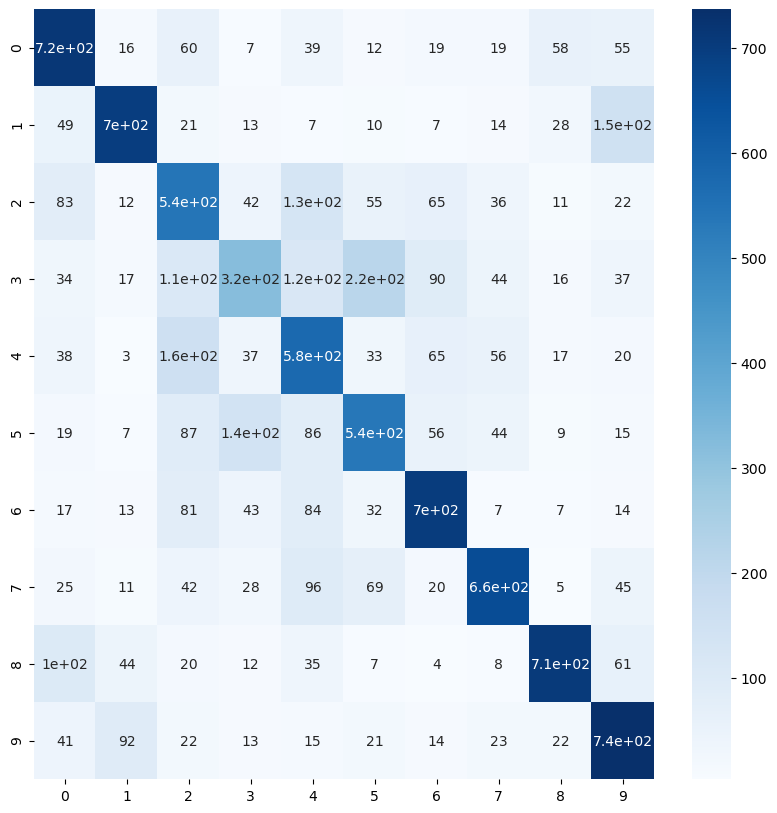

In [54]:
cf= confusion_matrix(test_labels, predicted_classes)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cf, annot=True, cmap='Blues', ax=ax)
plt.show()

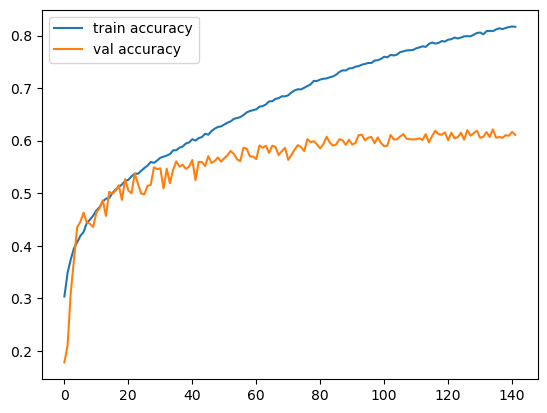

In [64]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

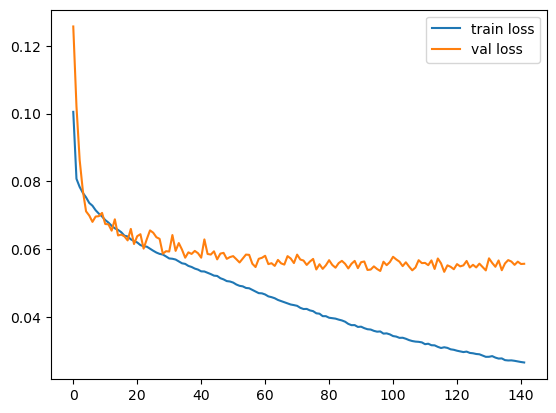

In [65]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Comment
### Dokładność na zbiorze trenującym -> 82%
### Dokładność na zbiorze testowym -> 62 %
### W procesie uczenia wystąpiło zjawisko overfittingu 